In [1]:
from keras.layers import Input, Lambda, Dense, Flatten



Using TensorFlow backend.


In [2]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [8]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.models import Model
import os

In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [5]:
TRAIN_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/"
TEST_DIR =  "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/"
VAL_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/"

In [6]:
TRAIN_DIR

'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/'

In [10]:
total_images_train_normal = os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/')
total_images_train_pneumonia = os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/')

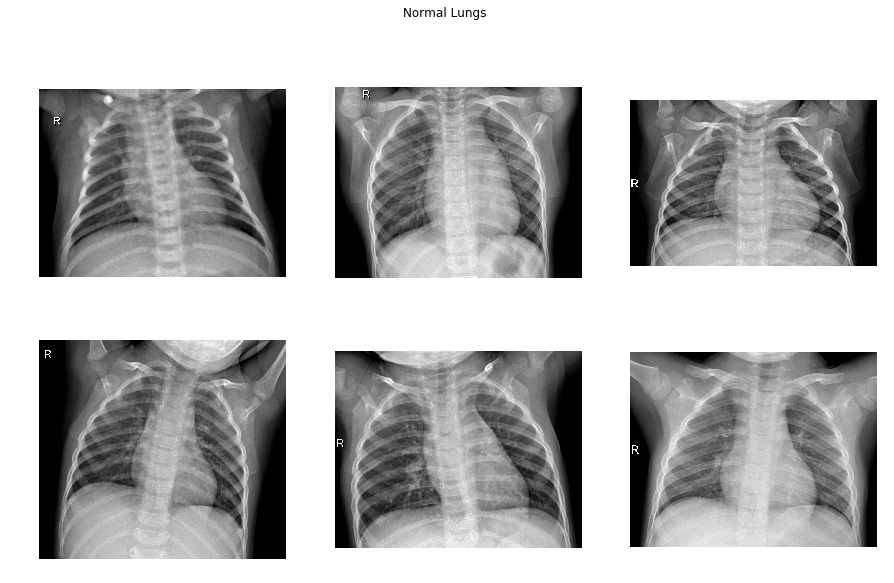

In [15]:
import pandas as pd
import random
import cv2
sample_normal = random.sample(total_images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Lungs')
plt.show()

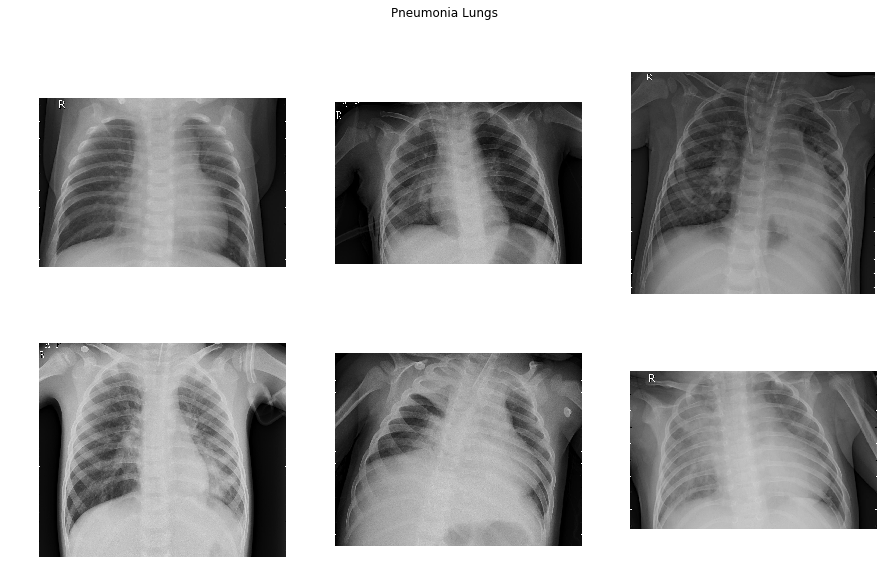

In [18]:
sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Pneumonia Lungs')
plt.show()

In [20]:
  # useful for getting number of classes
folders = glob('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/*')

In [21]:
folders

['/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA']

In [23]:
classes = len(folders)                                  
print(classes)

2


In [24]:
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


87916544/87910968 [==============================] - 3s 0us/step


In [25]:
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization

In [26]:
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [27]:
# Callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [29]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')
val_set= val_datagen.flow_from_directory( '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')
r = model.fit_generator(
           training_set, steps_per_epoch=len(training_set) , 
           epochs=5, validation_data=val_set, 
           validation_steps=len(val_set), callbacks=[checkpoint, lr_reduce])

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/5
163/163 [==============================] - 174s 1s/step - loss: 0.2133 - accuracy: 0.9221 - val_loss: 1078.4547 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 125s 765ms/step - loss: 0.1332 - accuracy: 0.9549 - val_loss: 0.2495 - val_accuracy: 0.8750
Epoch 3/5
163/163 [==============================] - 129s 791ms/step - loss: 0.1101 - accuracy: 0.9635 - val_loss: 0.6051 - val_accuracy: 0.7500

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/5
163/163 [==============================] - 130s 798ms/step - loss: 0.0844 - accuracy: 0.9755 - val_loss: 0.2512 - val_accuracy: 0.9375
Epoch 5/5
163/163 [==============================] - 131s 802ms/step - loss: 0.0506 - accuracy: 0.9829 - val_loss: 0.2276 - val_accuracy: 0.8750

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.00000042747

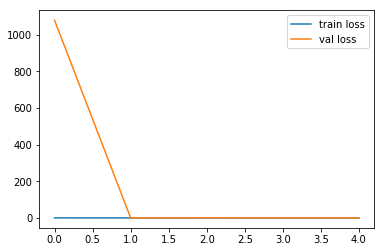

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

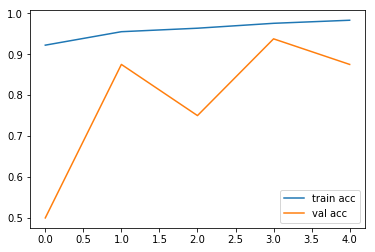

<Figure size 432x288 with 0 Axes>

In [31]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [33]:
scores = model.evaluate_generator(test_set)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


accuracy: 87.98%
